In [2]:
import spacy
import pandas as pd
import numpy as np
import textblob
from textblob import TextBlob
import math 
import matplotlib.pyplot as plt

sp = spacy.load('en_core_web_md')

In [4]:
df = pd.read_csv('yelp_processed_v4.csv')
df = df[:500]

In [5]:
# test: extract sentiment for a specific topic

review_text = "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. The food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker."
topics = ['location', 'service', 'quality', 'atmosphere', 'value']

vocab_doc = " ".join([r for r in df['text']])
vocab_doc = " ".join(set(vocab_doc.split()))
vocab_doc = sp(vocab_doc)

# get similar words in existing dataset
def get_similar_words(topic, n=5, threshold=0.5):
    topic_token = sp(topic)
    similar_words = []

    # print(topic.upper())

    # compare with words in vocabulary
    for word in vocab_doc: 
        if word.has_vector and word.is_alpha: 
            similarity = topic_token.similarity(word)
            if similarity > threshold: 
                similar_words.append((word.text, similarity))

    # sort by similarity score
    similar_words = sorted(similar_words, key=lambda x: x[1], reverse=True)# [:n]
    return [word[0] for word in similar_words]

for i in topics: 
    get_similar_words(i, vocab_doc)

In [ ]:
all_losses = []
all_thresholds = [0.5, 0.51, 0.52, 0.53, 0.54, 0.55]

def extract_topic_sentiment(text, topic, threshold): 
    doc = sp(text)

    # extract similar words
    similar_words = get_similar_words(topic, threshold=threshold)

    # sentences for now, but can make it phrases later 
    related_sentences = [
        sent.text for sent in doc.sents if any(word in sent.text.lower() for word in [topic] + similar_words)
    ]

    # sentiment score for extracted sentence
    sentiment_scores = []
    for sentence in related_sentences: 
        #print(sentence)
        blob = TextBlob(sentence)
        sentiment_scores.append(blob.sentiment.polarity)

    # average sentiment score for topic
    if sentiment_scores: 
        avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
        return avg_sentiment
    else: 
        return None
    
print("RELATED WORDS: ")
[print(f"TOPIC {topic.upper()}: {get_similar_words(topic, threshold=0.5)}") for topic in topics]


for th in (all_thresholds):
    no_sentiment = 0
    loss = []
    len_no_sentiments = []
    for row in range(1,500):
        review = df['og_text'][row]
        stars = df['stars'][row]

        sentiments = []

        for topic in topics: 
            sentiment = extract_topic_sentiment(review, topic, threshold=th)

            if sentiment is not None: 
                #print(f'Sentiment for {topic}: {sentiment}')
                sentiments.append(sentiment)
            #else: 
                #print(f'No sentiment found for {topic}')


        if len(sentiments) == 0: 
            #print("NO SENTIMENT FOUND FOR REVIEW!")
            no_sentiment += 1
            sentiment_score = 0.5 # add 0.5 to account for negatives
            len_no_sentiments.append((review, len(review)))
            
        else: 
            sentiment_score = (sum(sentiments) / len(sentiments)) + 0.5

        #print(sentiments)
        
        star_score = (int)(stars) / 5

        #print('Average sentiment: ', sentiment_score) 
        #print('Stars: ', star_score)
        loss.append(abs(sentiment_score - star_score))


    print("-----------------------")
    print("THRESHOLD: ", th)
    print("Average loss: ", sum(loss) / len(loss))
    all_losses.append((sum(loss) / len(loss)))
    print(len_no_sentiments)

    print(f'Total reviews without sentiment: {no_sentiment}')

        


RELATED WORDS: 
TOPIC LOCATION: ['location', 'timing', 'correct', 'gage', 'timely', 'consistent', 'accurately', 'precisely', 'detailed', 'questionable', 'trusted', 'reputable', 'recollection', 'chart', 'equation', 'challenging', 'small', 'thoroughly', 'usually', 'often', 'also', 'typically', 'complex', 'completely', 'excellent', 'extremely', 'definitely', 'yet', 'equally', 'certainly', 'busy', 'aware', 'perfectly', 'many', 'generally', 'totally', 'became', 'however', 'indeed', 'particularly', 'neat', 'normally', 'comfortably', 'beautifully', 'difficult', 'pleased', 'consistently', 'close', 'highly', 'familiar', 'especially', 'super', 'as', 'beautiful', 'reasonably', 'easily', 'fairly', 'relatively', 'popular', 'well', 'unusual', 'unique', 'varied', 'comfortable', 'truly', 'remain', 'rare', 'short', 'easy', 'immensely', 'quite', 'surroundings', 'impressed', 'surprisingly', 'pretty', 'incredibly', 'packed', 'great', 'absolutely', 'fitting', 'suited', 'is', 'long', 'quick', 'charming', 's

KeyboardInterrupt: 

In [ ]:
plt.plot(all_thresholds,  all_losses)
plt.xlabel('Threshold')
plt.ylabel('Average Loss')
plt.title('Average Loss on Sentiment Versus Star Value over k-means thresholds, sampled on 500 reviews')
plt.show()

NameError: name 'all_thresholds' is not defined

![500 review sample threshold test.png](<attachment:500 review sample threshold test.png>)
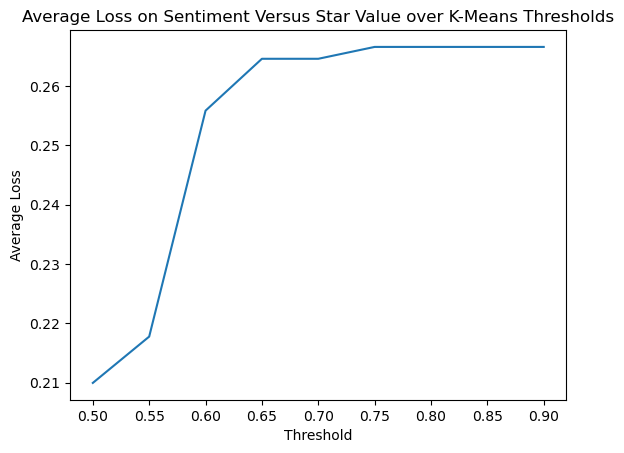

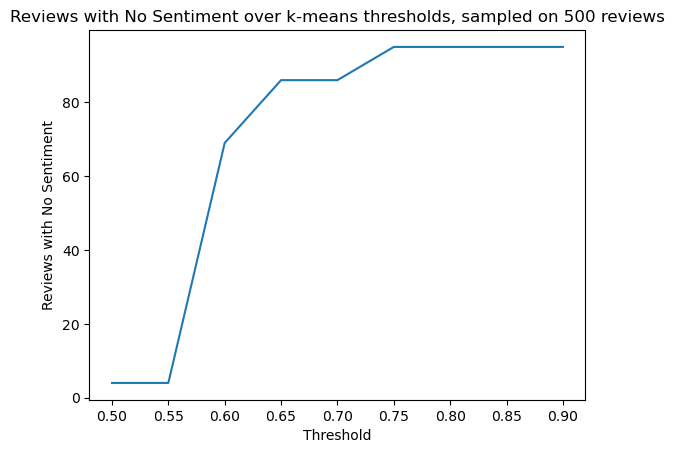

In [11]:
# reviews with no sentiment
all_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
all_no_sentiment = [4, 4, 69, 86, 86, 95, 95, 95, 95]

plt.plot(all_thresholds, all_no_sentiment)
plt.xlabel('Threshold')
plt.ylabel('Reviews with No Sentiment')
plt.title('Reviews with No Sentiment over k-means thresholds, sampled on 500 reviews')
plt.show()